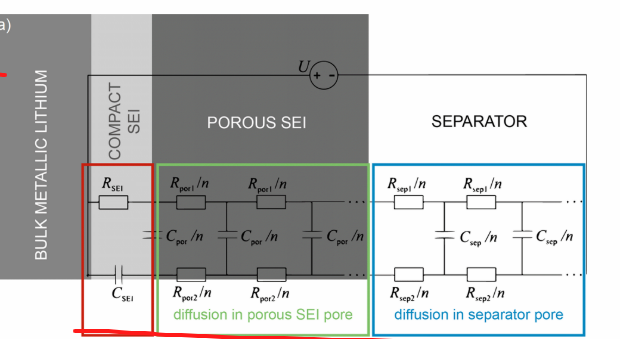 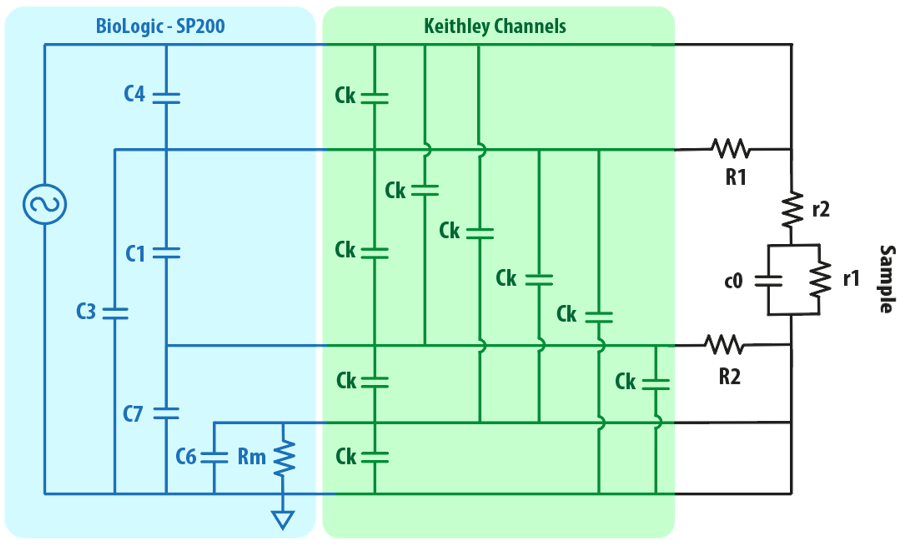

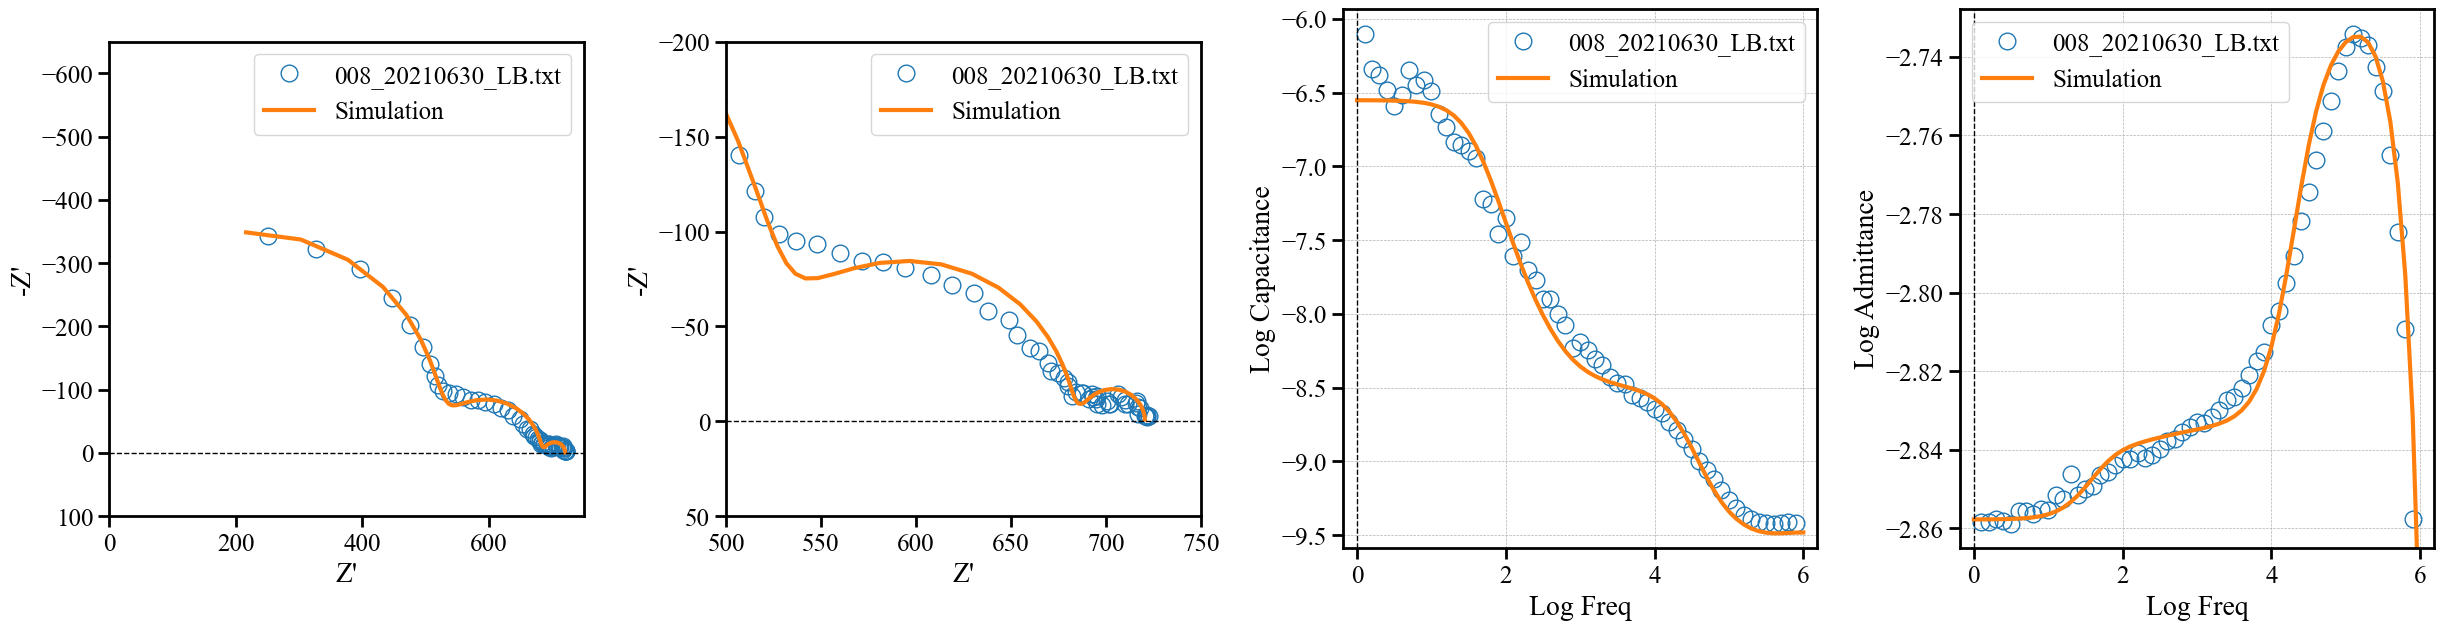

In [3]:
from sympy.interactive import printing
printing.init_printing(use_latex =True)
from sympy import *
import numpy as np
import cmath
import matplotlib.pyplot as plt
import os
#_____________________________________________________________________________________________________________________________________________
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10
plt.rcParams['lines.linewidth'] = 2
#from numpy.linalg import svd
#from scipy.optimize import leastsq, least_squares, minimize, differential_evolution
#from lmfit import Model
#import glob, os
#import random, time
#from pprint import pprint
#from collections import OrderedDict

from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

#Define the number of slice n=??
n = 1000
datafile_path = "008_20210630_Leftbody+stray_sim,n=1000_ver2.txt"

data_file = '008_20210630_LB.txt'
root_path = r'D:\OneDrive\Tran Tran Workstation\Bodyimpedance\DATA (3rd year)\BioLogic data\All data'
data_path = os.path.join(root_path, data_file)  # Use os.path.join to concatenate paths
results_folder = r'D:\OneDrive\Tran Tran Workstation\Bodyimpedance\DATA (3rd year)\BioLogic data\Fit result'
#Function to read data, use for text file and mtp file.
    
def read_data(path, freq_lower_bound, freq_upper_bound):
    df = pd.read_csv(path, header=None, sep='\t')
    df = df.reset_index()
    F0 = df.iloc[:, 1]
    Z0 = df.iloc[:, 2] + 1j*df.iloc[:, 3]
    
     # Limiting the frequency range
    mask = (F0 >= freq_lower_bound) & (F0 <= freq_upper_bound)
    df = df[mask]
    F = F0[mask]
    Z = Z0[mask]
    
    return df.index, F, Z

# Define your frequency boundaries here
freq_lower_bound = 0.1  # Example lower bound
freq_upper_bound = 10**6 # Example upper bound

index, F, Z = read_data(data_path, freq_lower_bound, freq_upper_bound)
for i, f, z in zip(index, F, Z):
    #print("{:02d} {:10.5e} {:10.5e} {:10.5e}".format(i, f, np.real(z), np.imag(z)))
    if i==59:
        R_segment = np.real(z)

freq_exp=0 #frequency [Hz] exponent
Re=[]
Im=[]
freq=[]

#Parameters
# t- in body impedance, representative value for arms and legs representative value for trunks. Low frequency response.
#Body impedance
tplus_POR=0.695
tplus_SEP=0.73
Rliq_POR = 399
Rliq_SEP = 107
C_POR = 1.2e-8
apor = 1
C_SEP = 0.2e-4
asep = 1
#stray effect
C1 = 13.5e-12
C2 = 2.18e-10
C3 = 5.49e-10
C4 = 7.6e-12
C6 = 2.179e-10
C7 = C2 - C6
R1 = 65
R2 = 1
Ck = 1/(9.05e6*R_segment + 0.55e10)

#Rp2 = 2 #Rpor2
#Rs1 = 18 #Rsep1
#Rs2 = 2.5 #Rsep1
Rsei = 0
Qsei = 1e-15 #Q_SEI
asei = 1 #alpha SEI



while freq_exp<6:
    f = 10 ** freq_exp
    w = 2 * np.pi * f
    iw = 1j * 2 * np.pi * f
    #w=2*np.pi*10**freq_exp
    ZC1 = 1/(iw*C1)
    ZC3 = 1/(iw*C3)
    ZC7 = 1/(iw*C7)
    ZRmC6 = 1000/(1+iw*1000*C6)
    ZR1C4 = R1/(1+iw*R1*C4)
    ZR2 = R2
    ZCk = 1/(iw*Ck)
    ZA = Rsei #R_SEI part
    ZB = 1/(iw**asei*Qsei) #C_SEI part
    Z_Cp = 1/(iw**apor*C_POR) #C_por
    Z_Cs = 1/(iw**asep*C_SEP) #C_sep
    Rp1=Rliq_POR/tplus_POR
    Rp2=Rliq_POR/(1-tplus_POR)
    Rs1=Rliq_SEP/tplus_SEP
    Rs2=Rliq_SEP/(1-tplus_SEP)
    
    #Matrices construction
    #Matrix A1
    a1 = np.eye(n+3, n+3, k=-1, dtype=np.complex128) * (-n*Z_Cp) #need to change dtype to np.complex128 when working in matrix solving
    a1 += np.eye(n+3, n+3, k=0, dtype=np.complex128) * (Rp1/n + 2*n*Z_Cp + Rp2/n)
    a1 += np.eye(n+3, n+3, k=+1, dtype=np.complex128) * (-n*Z_Cp)
    a1[0,0] = ZA + Rp1 + Rs1
    a1[1,1] = ZA + n*Z_Cp + ZB
    #a1[size-1, size-1] = Rs1/n + n*Z_Cs + Rs2/n
    a1[0,1] = -ZA
    a1[1,0] = -ZA
    a1[0,2:n+2] = -Rp1/n
    a1[2:n+2,0] = -Rp1/n
    a1[0,n+2:2*n+2] = -Rs1/n
    a1[n+2:2*n+2,0] = -Rs1/n
    a1[n+2,n+2] = Rs1/n + n*Z_Cp + n*Z_Cs + Rs2/n
    #MAtrix A2
    a2=np.zeros(shape=(n+3,n-1),dtype=np.complex128)
    a2[0,0:n+2]=-Rs1/n
    a2[n+2,0]=-n*Z_Cs
    #MAtrix B1
    b1=np.transpose(a2)
    #MAtrix B2
    b2 = np.eye(n-1, n-1, k=-1, dtype=np.complex128) * (-n*Z_Cs) #need to change dtype to np.complex when working in matrix solving
    b2 += np.eye(n-1, n-1, k=0, dtype=np.complex128) * (Rs1/n + 2*n*Z_Cs + Rs2/n)
    b2 += np.eye(n-1, n-1, k=+1, dtype=np.complex128) * (-n*Z_Cs)
    b2[n-2,n-2]=Rs1/n+n*Z_Cs+Rs2/n
    
    #Final big matrix
    FIRST=np.concatenate((a1,a2), 1)
    SECOND=np.concatenate((b1,b2), 1)
    final_matrix=np.concatenate((FIRST,SECOND), 0)
    
    bb=np.zeros(2*n+2,dtype=np.complex128)
    bb[0]=1+1j
    x=np.linalg.solve(final_matrix,bb)
    Z1=(1+1j)/(x[0])
    Z0=(ZC1*ZCk*(Z1*ZC3*ZC7*ZCk**2 + Z1*ZC3*ZCk**2*ZR2 + Z1*ZC3*ZCk**2*ZRmC6 + ZC3*ZCk**2*ZR2*ZRmC6 - ZC7*ZCk**2*ZR1C4*ZRmC6 + 2*Z1*ZC3*ZC7*ZCk*ZR2 + Z1*ZC3*ZC7*ZCk*ZR1C4 + 2*Z1*ZC3*ZC7*ZCk*ZRmC6 + Z1*ZC3*ZCk*ZR2*ZR1C4 - Z1*ZC7*ZCk*ZR2*ZR1C4 + 5*Z1*ZC3*ZC7*ZR2*ZRmC6 + 4*Z1*ZC3*ZCk*ZR2*ZRmC6 + Z1*ZC3*ZCk*ZR1C4*ZRmC6 - 2*Z1*ZC7*ZCk*ZR1C4*ZRmC6 + 5*Z1*ZC3*ZR2*ZR1C4*ZRmC6 - 5*Z1*ZC7*ZR2*ZR1C4*ZRmC6 + ZC3*ZC7*ZCk*ZR2*ZRmC6 - ZC3*ZC7*ZCk*ZR1C4*ZRmC6 + 2*ZC3*ZCk*ZR2*ZR1C4*ZRmC6 - 2*ZC7*ZCk*ZR2*ZR1C4*ZRmC6))/(Z1*ZC3*ZC7*ZCk**3 + ZC1*ZC3*ZC7*ZCk**3 + ZC1*ZC3*ZCk**3*ZR2 + ZC3*ZC7*ZCk**3*ZR2 + ZC1*ZC7*ZCk**3*ZR1C4 + ZC3*ZC7*ZCk**3*ZR1C4 + ZC1*ZCk**3*ZR2*ZR1C4 + ZC3*ZCk**3*ZR2*ZR1C4 + ZC7*ZCk**3*ZR2*ZR1C4 + 4*Z1*ZC1*ZC3*ZC7*ZCk**2 + 2*Z1*ZC1*ZC3*ZCk**2*ZR2 + 3*Z1*ZC3*ZC7*ZCk**2*ZR2 + 2*Z1*ZC1*ZC7*ZCk**2*ZR1C4 + 3*Z1*ZC3*ZC7*ZCk**2*ZR1C4 + Z1*ZC1*ZCk**2*ZR2*ZR1C4 + Z1*ZC3*ZCk**2*ZR2*ZR1C4 + Z1*ZC7*ZCk**2*ZR2*ZR1C4 + 4*ZC1*ZC3*ZC7*ZCk**2*ZR2 + 4*ZC1*ZC3*ZC7*ZCk**2*ZR1C4 + 4*ZC1*ZC3*ZCk**2*ZR2*ZR1C4 + 4*ZC1*ZC7*ZCk**2*ZR2*ZR1C4 + 6*ZC3*ZC7*ZCk**2*ZR2*ZR1C4 + 10*Z1*ZC1*ZC3*ZC7*ZCk*ZR2 + 10*Z1*ZC1*ZC3*ZC7*ZCk*ZR1C4 + 25*Z1*ZC1*ZC3*ZC7*ZR2*ZR1C4 + 5*Z1*ZC1*ZC3*ZCk*ZR2*ZR1C4 + 5*Z1*ZC1*ZC7*ZCk*ZR2*ZR1C4 + 10*Z1*ZC3*ZC7*ZCk*ZR2*ZR1C4 + 15*ZC1*ZC3*ZC7*ZCk*ZR2*ZR1C4)
    #print(10**freq_exp,Z0.real,Z0.imag)
    Re.append(Z0.real)
    Im.append(Z0.imag)
    freq.append(10**freq_exp)
    freq_exp+=0.1

#plt.plot(Re, Im, '+')

# Use plt.gca() to get the current axes and set the aspect ratio on that axes.
#plt.gca().set_aspect('equal')

#plt.show()

#Exporting data
data = np.array([freq, Re, Im])
data = data.T

with open(datafile_path, 'w+') as datafile_id:
    np.savetxt(datafile_id, data)
    

#print("Number of data : {:3}".format(len(index)))
#print("No.Frequency   Z'          Z'' ")
Cap_sim = - np.divide(Im, (np.square(Im) + np.square(Re))*2*np.pi*freq)
Cap_raw = -np.divide(np.real(Z),(np.square(np.real(Z)) + np.square(np.imag(Z)))*2*np.pi*F)
#for i, f, z in zip(index, F, Z):
    #print("{:02d} {:10.5e} {:10.5e} {:10.5e}".format(i, f, np.real(z), np.imag(z)))
fig, (ax1, ax2, ax4, ax5) = plt.subplots(1,4, figsize=(30, 7))
# A function to apply the common settings to each ax
def apply_common_settings(ax):
    # Set spine (border) thickness
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    
    # Set major and minor tick thickness and label size
    ax.tick_params(axis='both', which='major', width=2, size=8, labelsize=18)  # Adjusts the font size for tick labels
    ax.tick_params(axis='both', which='minor', width=1, size=4, labelsize=18)  # Minor ticks
    
    # Set the axis labels with specific font size
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    
    ax.legend(loc='best', fontsize = 18)
    ax.invert_yaxis()
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Custom settings for each ax
# After plotting, apply the common settings which now include adjustments for labels and ticks
ax1.plot(np.real(Z), np.imag(Z), 'o', label=data_file, markerfacecolor='none', linewidth=1, markersize=12)
ax1.plot(Re, Im, label='Simulation', linewidth=3)
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim([0, 750])
ax1.set_ylim([-650, 100])
ax1.set_xlabel("Z'")
ax1.set_ylabel("-Z'")
apply_common_settings(ax1)

ax2.plot(np.real(Z), np.imag(Z), 'o', label=data_file, markerfacecolor='none', linewidth=1, markersize=12)
ax2.plot(Re, Im, label='Simulation', linewidth=3)
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim([500, 750])
ax2.set_ylim([-200, 50])
ax2.set_xlabel("Z'")
ax2.set_ylabel("-Z'")
apply_common_settings(ax2)

# Similar adjustments for ax3, ax4, and ax5, followed by applying common settings
#ax3.plot(np.log10(np.abs(np.real(Z))), np.log10(np.abs(np.imag(Z))), 's', label=data_file, markerfacecolor='none', linewidth=1, markersize=7)
#ax3.plot(np.log10(np.abs(Re)), np.log10(np.abs(Im)), label='Simulation', linewidth=3)
#ax3.set_xlabel("Log Z'")
#ax3.set_ylabel("Log -Z''")
#apply_common_settings(ax3)

ax4.plot(np.log10(F), np.log10(np.abs(np.real(1/(1j * 2 * np.pi * F * Z)))), 'o', label=data_file, markerfacecolor='none', linewidth=1, markersize=12)
ax4.plot(np.log10(freq), np.log10(Cap_sim), label='Simulation', linewidth=3)
ax4.set_xlabel('Log Freq')
ax4.set_ylabel('Log Capacitance')
ax4.grid(True, which="both", ls="--", linewidth=0.5)
apply_common_settings(ax4)
log_F_min, log_F_max = np.log10(np.min(F)), np.log10(np.max(F))
log_Cap_data = np.log10(np.abs(np.real(1/(1j * 2 * np.pi * F * Z))))
log_Cap_min, log_Cap_max = np.min(log_Cap_data), np.max(log_Cap_data)
F_margin = (log_F_max - log_F_min) * 0.05  # 5% of the frequency data range
Cap_margin = (log_Cap_max - log_Cap_min) * 0.05  # 5% of the capacitance data range
ax4.set_xlim(log_F_min - F_margin, log_F_max + F_margin)
ax4.set_ylim(log_Cap_min - Cap_margin, log_Cap_max + Cap_margin)

ax5.plot(np.log10(F), np.log10(np.abs(np.real(Z)/(np.real(Z)**2 + np.imag(Z)**2))), 'o', label=data_file, markerfacecolor='none', linewidth=1, markersize=12)
ax5.plot(np.log10(freq), np.log10(np.abs(Re/(np.square(Re) + np.square(Im)))), label='Simulation', linewidth=3)
ax5.set_xlabel('Log Freq')
ax5.set_ylabel('Log Admittance')
ax5.grid(True, which="both", ls="--", linewidth=0.5)
apply_common_settings(ax5)
log_F_min, log_F_max = np.log10(np.min(F)), np.log10(np.max(F))
log_Adm_data = np.log10(np.abs(np.real(Z)/(np.real(Z)**2 + np.imag(Z)**2)))
log_Adm_min, log_Adm_max = np.min(log_Adm_data), np.max(log_Adm_data)
F_margin = (log_F_max - log_F_min) * 0.05  # 5% of the data range
Adm_margin = (log_Adm_max - log_Adm_min) * 0.05  # 5% of the data range
ax5.set_xlim(log_F_min - F_margin, log_F_max + F_margin)
ax5.set_ylim(log_Adm_min - Adm_margin, log_Adm_max + Adm_margin)

plt.subplots_adjust(wspace=0.3)
plt.show()

# Strip the extension from data_file and create the figure filename
figure_name = data_file.split('.')[0] + '_n=1000.png'  # This will create '008_20210630_UpB.png'

# Full path for saving the figure
save_path = f'D:\\OneDrive\\Tran Tran Workstation\\PhD dissertation\\Figure\\BIA\\{figure_name}'

# Now, to save the figure:
fig.savefig(save_path, dpi=300)
